# TD6. Introduction to Convolutional neural networks

In [260]:
import github_command as git

In [725]:
git.push(file_to_transfer='TD6_CNN.ipynb',
         message='TD6 - added matrix notation',
         repos='TDs_ESILV.git')

In [226]:
import os
import random
import matplotlib.pyplot as plt

In [85]:
%matplotlib inline

In [227]:
[x for x in os.listdir('./') if x.startswith('data')]

['data_dog', 'data_cat', 'data_accidents']

In [228]:
random.choices(os.listdir('data_dog'), k=3)

['2502.jpg', '3717.jpg', '528.jpg']

## Checking images in directories

In [257]:
def show_k_images(path, k=3):
    import matplotlib.pyplot as plt
    from PIL import Image # used for loading images
    nb_cols = 2 if k%2 == 0 else 3
    fig, axes = plt.subplots(figsize=(nb_cols*5,k//nb_cols*5), nrows=k//nb_cols + k%nb_cols, ncols=nb_cols)
    for ax, (ax_number, choice) in zip(axes.flat, enumerate(random.choices(os.listdir(path), k=k))):
        ax.imshow(X=Image.open(path+choice))

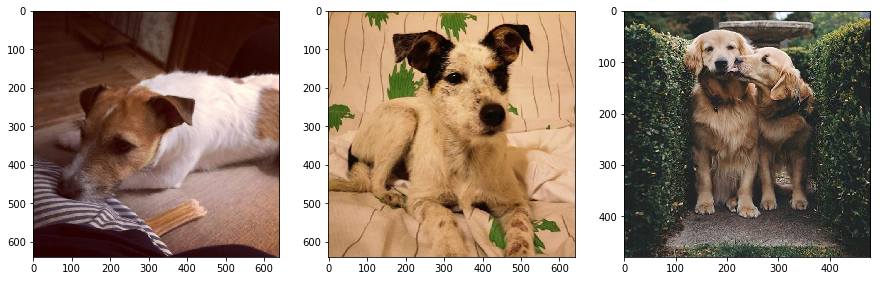

In [258]:
show_k_images('data_dog/', 3)

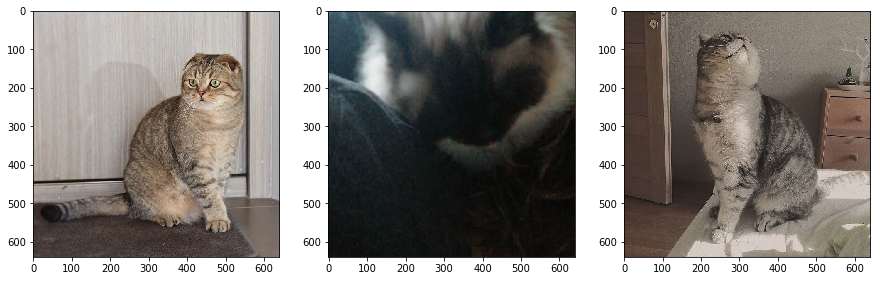

In [259]:
show_k_images('data_cat/', 3)

## Load data and (maybe) preprocess it

In [263]:
from PIL import Image # used for loading images

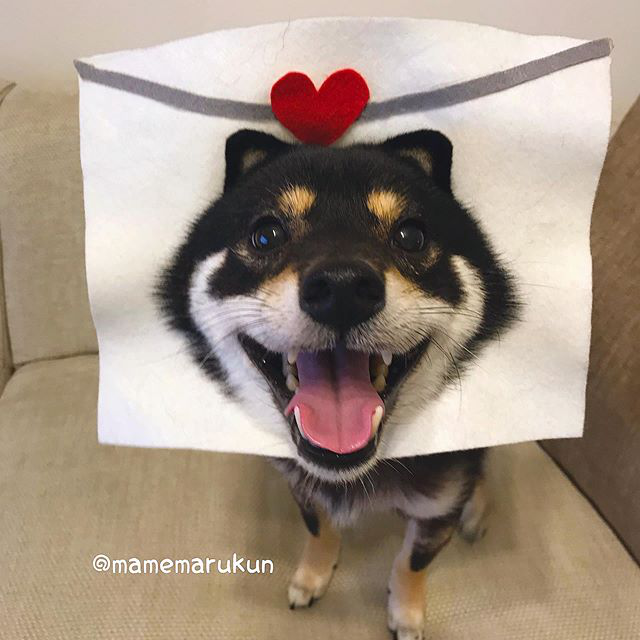

In [265]:
img = Image.open('data_dog/1.jpg')
img

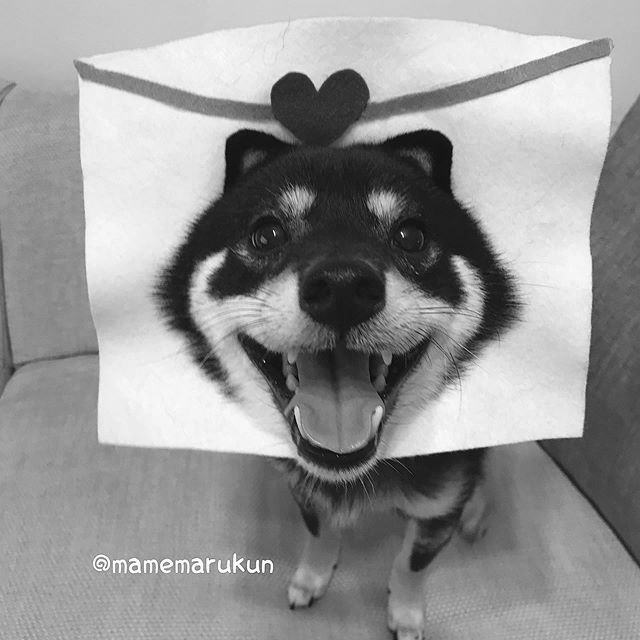

In [266]:
img.convert('L')

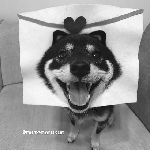

In [268]:
img.convert('L').resize((150,150))

In [270]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

## On le veut sous forme d'une liste de np.arrays

### Exemple de manipulation d'image et résultat sous forme de tableau (numpy array)

In [706]:
np.array(img.resize((1,4))) # Image sur 3 cannaux (R/G/B)

array([[[217, 192, 170]],

       [[ 46,  36,  37]],

       [[177, 108, 113]],

       [[135, 103,  64]]], dtype=uint8)

In [707]:
np.array(img.convert('L').resize((1,4)))

array([[196],
       [ 39],
       [129],
       [108]], dtype=uint8)

In [708]:
test = np.array([1,2,3])

In [709]:
np.expand_dims(test, axis=-1)

array([[1],
       [2],
       [3]])

### Load des photos dans le bon format 

Mais qu'est ce que le format attendu en entrée du réseau de neurones ?

In [713]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

From Stackoverflow:

If you look at the Keras documentation, you will observe that for Sequential model's first layers takes the required input. So for example, your first layer is Dense layer with input dimension as 400. Hence each input should be a numpy array of size 400. You can pass a 2D numpy array with size (x,400). (I assume that x is the number of input examples). Your output has 13 dimensions for each output document and hence your final Dense layer has to be model.add(Dense(13)) instead of model.add(Dense(1)).

Coming to how it knows, it takes the first dimension of X as number of training examples and second dimension as the size of each example. Similarly for output layer.

In [714]:
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        print( "estimated elapsed time = {}".format(te - ts))
        return result
    return timed

In [716]:
@timeit
def load_all_photos(path, binary_label):
    import os, numpy as np
    data = []
    for image in os.listdir(path)[:1000]:
        try:
            data.append( 
                np.array(Image.open(path+image).convert('L').resize((150,150), Image.ANTIALIAS))
            )
        except:
            continue
    return np.array(data), np.array( binary_label* len(data))

In [717]:
X_dogs, y_dogs = load_all_photos('data_dog/', [1])
X_cats, y_cats = load_all_photos('data_cat/', [0])

estimated elapsed time = 10.617992877960205
estimated elapsed time = 10.251427173614502


In [718]:
X = np.concatenate((X_dogs, X_cats))
y = np.concatenate((y_dogs, y_cats))

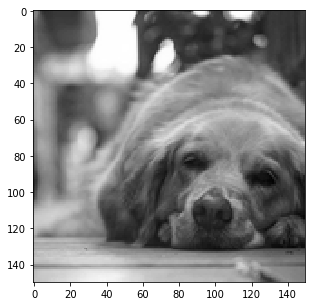

In [719]:
plt.imshow(X[0], cmap='gist_gray')

## 3. Prepare dataset 

In [775]:
def split(X, y, train_size = 0.7):
    """ Randomly split the train and test sets from data according to train_size ratio """
    import random, numpy as np
    assert len(X) == len(y)
    ## choose k unique randoms elements from sequence range(len(data))
    train_choices = random.sample(population=range(len(X)), 
                                      k=round(train_size*len(X)))
    ## take the previously unselected rest as test sample
    test_choices = list( set(range(len(X))) - set(train_choices) )
    
    return X[train_choices],y[train_choices],\
            X[test_choices], y[test_choices]

In [776]:
X_train, y_train, X_test, y_test = split(X, y)

In [777]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1398, 150, 150), (1398,), (599, 150, 150), (599,))

(<matplotlib.image.AxesImage at 0xb394d0ba8>, 1)

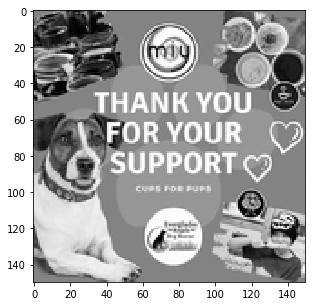

In [780]:
plt.imshow(X_train[4], cmap='gist_gray'), y_train[4]

In [781]:
x_train = np.random.random((5, 2))

In [782]:
x_train

array([[0.59960109, 0.08144539],
       [0.30793746, 0.31369873],
       [0.12899332, 0.28087368],
       [0.0804524 , 0.16914952],
       [0.53941084, 0.75222318]])

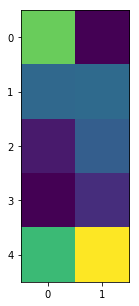

In [783]:
plt.imshow(x_train)

## 2. Create a simple CNN model using high-level Keras library

In [784]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.optimizers import SGD

#### First Conv2D
* **for image input channels == 3**
   - 32 filters for each channel (*3) = 96
   - 32 bias 
   - 3*3 = 9 weights per filter
   - TOTAL : 864 + 32 = 896 params
* **for image input channels == 1**
 
   - 32 filters for each channel (*1) = 32
   - 32 bias 
   - 3*3 = 9 weights per filter
   - TOTAL : 288 + 32 = 320 params

#### Second Conv2D
***Does not depend on input image size***
   - 32 filters here
   - 32 bias 
   - 3*3 = 9 weights per filter
   - TOTAL : 3 * 3 * 32 * (32 of the previous layer) + 32 = 9248 params 

#### Dense layer 
 - (34 \* 34 \* 64) (image size outputing = number of neurons after convolutions previously flattened) x 256 + 256 

## NOTATIONS VECTEURS MATRICES ET MATRICE DES POIDS NOTAMMENT + Rappels

*** Matrix multiplication *** of (m rows, n columns) with (n rows, l columns)
* m x n \* n x l   => m x l
* 1 x n \* n x l   => 1 x l => **X** \* **W_(ij)** (then nrows for n neurons)

X is a vector identified as 1-row matrice

h = sigma ( **X_(1i)** \* **W_(ij)** )   with i = ith neuron from first layer to j = jth neuron from 2nd layer ( 1 x n \* n x l )

comme t(t(A)) = A 

=>

h = sigma ( **W_(ij)^t** \* **X_(1i)**^t )

<=> h = sigma ( **W_(ji)** \* **X_(i1)** )

In [800]:
def keras_model():
    """ VGG-like convnet — according to https://keras.io/getting-started/sequential-model-guide/#specifying-the-input-shape"""
    model = Sequential()
    # input: 150x150 images with 1 channels -> (100, 100, 1) tensors.
    # this applies 32 convolution filters of size 3x3 each.
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    #model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25)) # 25% to be dropped = leaving 75% of the fraction inputs neurons

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy', optimizer=sgd)
    return model

In [801]:
model = keras_model()

In [802]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 73, 73, 32)        128       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 69, 69, 64)        36928     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 34, 34, 64)        0         
__________

In [795]:
X_train = np.expand_dims(X_train, axis=-1)

In [803]:
model.fit(x=X_train, y=y_train, epochs=20, batch_size=32)

Epoch 1/20
1398/1398 [==============================] - 86s 61ms/step - loss: 3.3122
Epoch 2/20
1398/1398 [==============================] - 78s 56ms/step - loss: 1.3165
Epoch 3/20
1398/1398 [==============================] - 82s 59ms/step - loss: 0.6935
Epoch 4/20
1398/1398 [==============================] - 80s 58ms/step - loss: 0.6916
Epoch 5/20
1398/1398 [==============================] - 76s 55ms/step - loss: 0.6911
Epoch 6/20
1398/1398 [==============================] - 77s 55ms/step - loss: 0.6913
Epoch 7/20
1398/1398 [==============================] - 76s 55ms/step - loss: 0.6899
Epoch 8/20
1398/1398 [==============================] - 77s 55ms/step - loss: 0.6863
Epoch 9/20
1398/1398 [==============================] - 77s 55ms/step - loss: 0.6889
Epoch 10/20
1398/1398 [==============================] - 77s 55ms/step - loss: 0.6903
Epoch 11/20
1398/1398 [==============================] - 77s 55ms/step - loss: 0.6860
Epoch 12/20
1398/1398 [==============================] - 77s 55

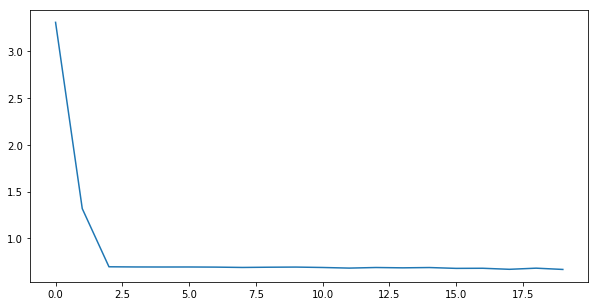

In [812]:
plt.plot(model.history.history['loss'])

In [814]:
X_test = np.expand_dims(X_test, axis=-1)

In [815]:
score = model.evaluate(X_test, y_test, batch_size=32)

599/599 [==============================] - 11s 18ms/step


In [816]:
score

0.7025944708981776